<a id="toc"></a>
# barc4sr: 
## Example 01 - Emission spectra for an ideal and tabulated ondulator

[rafael.celestre@synchrotron-soleil.fr](mailto:rafael.celestre@synchrotron-soleil.fr)

<hr style="border:1px solid orange">


In [1]:
__author__ = ['Rafael Celestre']
__contact__ = 'rafael.celestre@synchrotron-soleil.fr'
__license__ = 'GPL-3.0'
__copyright__ = 'Synchrotron SOLEIL, Saint Aubin, France'
__created__ = '22/MAR/2024'
__changed__ = '16/JUN/2024'

import os
import sys

import barc4sr.sr_undulator as und
import numpy as np
from barc4plots.barc4plots import PlotManager
from barc4sr.aux_processing import read_spectrum
from barc4sr.aux_utils import (
                            ElectronBeam,
                            MagneticStructure,
                            SynchrotronSource,
                            read_electron_trajectory,
                            write_magnetic_field,
)

# checking we are using the correct python:
print(sys.executable)
print(sys.version)

# # benchmarking tools
# %load_ext autoreload
# %autoreload 2
# %matplotlib widget

c:\Users\celestre\AppData\Local\miniconda3\envs\oasys\python.exe
3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]


### Creation of SYNED input file (.json)

[Back to the top](#toc)

The SYNED Light Source file containing the electron beam parameters and the undulator parameters
is necessary for using barc4sr. While the preferred method for generating it remains [OASYS](https://oasys-kit.github.io/), 
barc4sr provides its own functions methods.


In [2]:
straight_section = ElectronBeam()

straight_section.from_twiss(energy=2.75, energy_spread=0.001025, current=0.500,
                            emittance=3.939e-9, coupling=1/100,
                            emittance_x=None, emittance_y=None,
                            beta_x=4.789, beta_y=3.7497, 
                            alpha_x=-0.3858, alpha_y=-0.7746,
                            eta_x=0.1804, eta_y=0.0044,
                            etap_x=0.0007, etap_y=-0.0025)

u64 = MagneticStructure(K_vertical=0.0,
                        K_horizontal=0.0,
                        period_length=64e-3,
                        number_of_periods=28.0)

u64.set_resonant_energy(50, 1, straight_section.energy_in_GeV, "v")

hermes = SynchrotronSource(straight_section, u64)
hermes.write_syned_config(".\light_sources\soleil_hu64.json", "SOLEIL-HU64")


In [3]:
ei = 35
ef = 375
ne = int((ef-ei)/0.1) + 1

## Ideal undulator

### Calculation of the **on-axis** spectrum of an ideal planar undulator

This example show different ways or calling ```sr_undulator.spectrum(*args, **kwargs)```
for a filament beam 20m downstream the centre of the straight section - no emittance nor 
energy spread are accounted for here. 

[Back to the top](#toc)

In [4]:
spectrum = und.spectrum(file_name=".\example_01\SOLEIL-U64mm_on_axis",
                        json_file=".\light_sources\soleil_hu64.json",
                        photon_energy_min=ei,
                        photon_energy_max=ef,
                        photon_energy_points=ne,
                        observation_point=20,
                        hor_slit=1e-23,
                        ver_slit=1e-23,
                        Kv_symmetry=-1,
                        electron_trajectory=True)

eTraj_ideal = read_electron_trajectory(r".\example_01\SOLEIL-U64mm_on_axis_eTraj.dat")

magField = np.asarray([eTraj_ideal["Z"], eTraj_ideal["Bx"], eTraj_ideal["By"], eTraj_ideal["Bz"]]).T
magField = write_magnetic_field(magField, r".\example_01\SOLEIL-U64mm_srw_magField.dat")

Undulator spectrum calculation using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... >>>.\example_01\SOLEIL-U64mm_on_axis_eTraj.dat<<< completed
> Performing on-axis spectrum from filament electron beam ... completed
Undulator spectrum calculation using SRW: finished.
>> Total elapsed time: 423.42 ms
>>> saving .\example_01\SOLEIL-U64mm_srw_magField.dat


Calculations for lower harmonics are usually very fast, but when moving away from the undulator regime into
the wiggler regime, calculations slow down. In this case, the calculations could/should be done in parallel:

```python
spectrum = und.spectrum(file_name=".\example_01\SOLEIL-U64mm_on_axis",
                        json_file=".\light_sources\soleil_hu64.json",
                        photon_energy_min=ei,
                        photon_energy_max=ef,
                        photon_energy_points=ne,
                        observation_point=20,
                        hor_slit=1e-23,
                        ver_slit=1e-23,
                        Kv_symmetry=-1,
                        electron_trajectory=True,
                        parallel=True)
```

.\example_01\SOLEIL-U64mm_on_axis_spectrum.h5


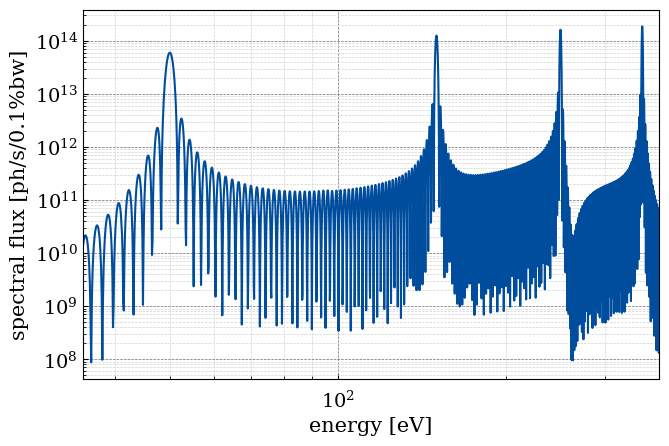

In [5]:
spectrum = read_spectrum(".\example_01\SOLEIL-U64mm_on_axis_spectrum.h5")

img = PlotManager(spectrum["spectrum"]["flux"],  spectrum["spectrum"]["energy"])
img.additional_info(None, "energy [eV]",  "spectral flux [ph/s/0.1%bw]")
img.aesthetics(400, True, True, 3 , 1, True, 4).info_1d_plot(0, None, 1, "-", False, 0, 1).plot_1d(enable=True)

### Calculation of the on spectrum of an ideal planar undulator **through a slit**

This example show different ways or calling ```sr_undulator.spectrum(*args, **kwargs)```
for a filament beam 20m downstream the centre of the straight section for a slit 20m (100 µrad) downstream the centre of the straight section - emittance and energy spread are taken into account in this calculation.

[Back to the top](#toc)

In [6]:
spectrum = und.spectrum(file_name=".\example_01\SOLEIL-U64mm_slit",
                        json_file=".\light_sources\soleil_hu64.json",
                        photon_energy_min=ei,
                        photon_energy_max=ef,
                        photon_energy_points=ne,
                        observation_point=20,
                        hor_slit=2e-3,
                        ver_slit=2e-3,
                        Kv_symmetry=-1)

Undulator spectrum calculation using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
> Performing flux through finite aperture (simplified partially-coherent simulation) ... completed
Undulator spectrum calculation using SRW: finished.
>> Total elapsed time: 221.58 ms


Calculations for lower harmonics are usually very fast, but when moving away from the undulator regime into
the wiggler regime, calculations slow down. In this case, the calculations could/should be done in parallel:

```python
energy, flux = und.undulator_spectrum(file_name=".\example_01\SOLEIL-U64mm_slit_par",
                                  json_file=".\light_sources\soleil_hu64.json",
                                  photon_energy_min=ei,
                                  photon_energy_max=ef,
                                  photon_energy_points=ne,
                                  observation_point=20,
                                  hor_slit=2e-3,
                                  ver_slit=2e-3,
                                  Kv_symmetry=-1,
                                  parallel = True)
```

In [7]:
spectrum = und.spectrum(file_name=".\example_01\SOLEIL-U64mm_slit_me",
                        json_file=".\light_sources\soleil_hu64.json",
                        photon_energy_min=ei,
                        photon_energy_max=ef,
                        photon_energy_points=ne,
                        observation_point=20,
                        hor_slit=2e-3,
                        ver_slit=2e-3,
                        Kv_symmetry=-1,
                        number_macro_electrons = 1000,
                        parallel = True)

Undulator spectrum calculation using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ... completed
> Electron trajectory calculation ... completed
> Performing flux through finite aperture (accurate partially-coherent simulation) in parallel... 
>>> ellapse time:
 Core 1: 63.59 s for 284 pts (E0 = 35.0 eV).
 Core 2: 68.29 s for 283 pts (E0 = 63.4 eV).
 Core 3: 70.50 s for 283 pts (E0 = 91.7 eV).
 Core 4: 73.84 s for 284 pts (E0 = 120.0 eV).
 Core 5: 68.60 s for 283 pts (E0 = 148.4 eV).
 Core 6: 75.50 s for 283 pts (E0 = 176.7 eV).
 Core 7: 77.20 s for 284 pts (E0 = 205.0 eV).
 Core 8: 75.55 s for 283 pts (E0 = 233.4 eV).
 Core 9: 84.75 s for 283 pts (E0 = 261.7 eV).
 Core 10: 79.14 s for 284 pts (E0 = 290.0 eV).
 Core 11: 85.94 s for 283 pts (E0 = 318.4 eV).
 Core 12: 85.31 s for 284 pts (E0 = 346.7 eV).
completed
Undulator spectrum calculation using SRW: finished.
>> Total elapsed time: 1 min 26.81 s


.\example_01\SOLEIL-U64mm_slit_spectrum.h5
.\example_01\SOLEIL-U64mm_slit_me_spectrum.h5


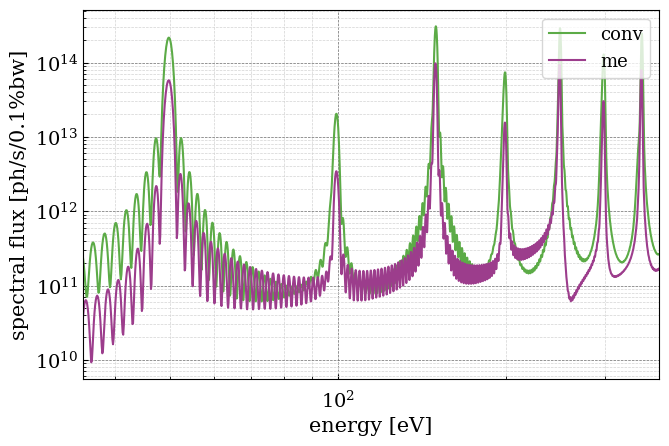

In [8]:
spectrum = read_spectrum([".\example_01\SOLEIL-U64mm_slit_spectrum.h5"])
img = PlotManager(spectrum["spectrum"]["flux"],  spectrum["spectrum"]["energy"])
img.additional_info(None, "energy [eV]",  "spectral flux [ph/s/0.1%bw]")
img.aesthetics(400, True, True, 3 , 1, True, 4).info_1d_plot(2, 'conv', 0, "-", False, 0, 1).plot_1d(enable=False)

spectrum_parallel = read_spectrum([".\example_01\SOLEIL-U64mm_slit_me_spectrum.h5"])
img.image = spectrum_parallel["spectrum"]["flux"]
img.x = spectrum_parallel["spectrum"]["energy"]
img.info_1d_plot(3, "me", 1, "-", False, 0, 1).plot_1d(enable=True, hold=True)


## Tabulated undulator

### Calculation of the **on-axis** spectrum of a tabulated planar undulator

This example show different ways or calling ```sr_undulator.spectrum(*args, **kwargs)```
for a filament beam 20m downstream the centre of the straight section - no emittance nor 
energy spread are accounted for here. 

[Back to the top](#toc)

In [9]:
energy, flux = und.spectrum(file_name=".\example_01\SOLEIL-tabU64mm_on_axis",
                            json_file=".\light_sources\soleil_hu64.json",
                            photon_energy_min=ei,
                            photon_energy_max=ef,
                            photon_energy_points=ne,
                            observation_point=20,
                            hor_slit=1e-23,
                            ver_slit=1e-23,
                            Kv_symmetry=-1,
                            electron_trajectory=True,
                            magnetic_measurement=r".\light_sources\tabulated_hu64.dat")

eTraj_ideal = read_electron_trajectory(r".\example_01\SOLEIL-tabU64mm_on_axis_eTraj.dat")
magField = np.asarray([eTraj_ideal["Z"], eTraj_ideal["Bx"], eTraj_ideal["By"], eTraj_ideal["Bz"]]).T
magField = write_magnetic_field(magField, r".\example_01\SOLEIL-tabU64mm_srw_magField.dat")

Undulator spectrum calculation using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ...  tabulated magnetic field ... completed
> Electron trajectory calculation ... >>>.\example_01\SOLEIL-tabU64mm_on_axis_eTraj.dat<<< completed
> Performing on-axis spectrum from filament electron beam ... completed
Undulator spectrum calculation using SRW: finished.
>> Total elapsed time: 426.41 ms
>>> saving .\example_01\SOLEIL-tabU64mm_srw_magField.dat


.\example_01\SOLEIL-tabU64mm_on_axis_spectrum.h5


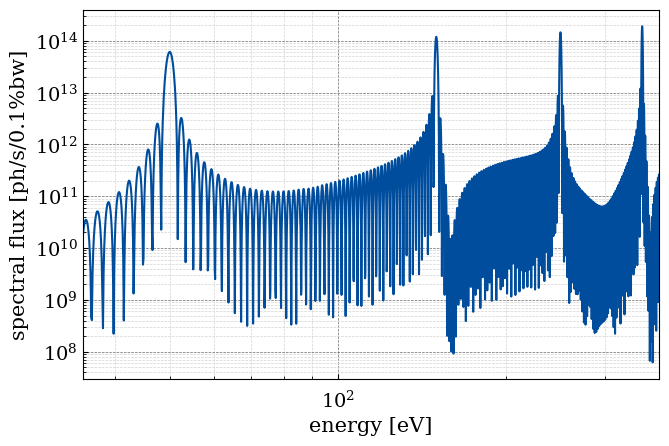

In [10]:
spectrum = read_spectrum([".\example_01\SOLEIL-tabU64mm_on_axis_spectrum.h5"])

img = PlotManager(spectrum["spectrum"]["flux"],  spectrum["spectrum"]["energy"])
img.additional_info(None, "energy [eV]",  "spectral flux [ph/s/0.1%bw]")
img.aesthetics(400, True, True, 3 , 1, True, 4).info_1d_plot(0, None, 1, "-", False, 0, 1).plot_1d(enable=True)

### Calculation of the on spectrum of an tabulated planar undulator **through a slit**

This example show different ways or calling ```sr_undulator.spectrum(*args, **kwargs)```
for a filament beam 20m downstream the centre of the straight section for a slit 20m (100 µrad) downstream the centre of the straight section - emittance and energy spread are taken into account in this calculation.

[Back to the top](#toc)

In [11]:
energy, flux = und.spectrum(file_name=".\example_01\SOLEIL-tabU64mm_slit_me",
                            json_file=".\light_sources\soleil_hu64.json",
                            photon_energy_min=ei,
                            photon_energy_max=ef,
                            photon_energy_points=ne,
                            observation_point=20,
                            hor_slit=2e-3,
                            ver_slit=2e-3,
                            Kv_symmetry=-1,
                            magnetic_measurement=r".\light_sources\tabulated_hu64.dat",
                            number_macro_electrons = 1000,
                            parallel = True,
                            )

Undulator spectrum calculation using SRW: please wait...
> Generating the electron beam ... completed
> Generating the magnetic structure ...  tabulated magnetic field ... completed
> Electron trajectory calculation ... completed
> Performing flux through finite aperture (accurate partially-coherent simulation) in parallel... 
>>> ellapse time:
 Core 1: 64.65 s for 284 pts (E0 = 35.0 eV).
 Core 2: 72.48 s for 283 pts (E0 = 63.4 eV).
 Core 3: 72.51 s for 283 pts (E0 = 91.7 eV).
 Core 4: 76.74 s for 284 pts (E0 = 120.0 eV).
 Core 5: 75.21 s for 283 pts (E0 = 148.4 eV).
 Core 6: 78.77 s for 283 pts (E0 = 176.7 eV).
 Core 7: 85.84 s for 284 pts (E0 = 205.0 eV).
 Core 8: 85.64 s for 283 pts (E0 = 233.4 eV).
 Core 9: 88.83 s for 283 pts (E0 = 261.7 eV).
 Core 10: 83.49 s for 284 pts (E0 = 290.0 eV).
 Core 11: 90.89 s for 283 pts (E0 = 318.4 eV).
 Core 12: 91.26 s for 284 pts (E0 = 346.7 eV).
completed
Undulator spectrum calculation using SRW: finished.
>> Total elapsed time: 1 min 31.29 s


.\example_01\SOLEIL-tabU64mm_slit_me_spectrum.h5


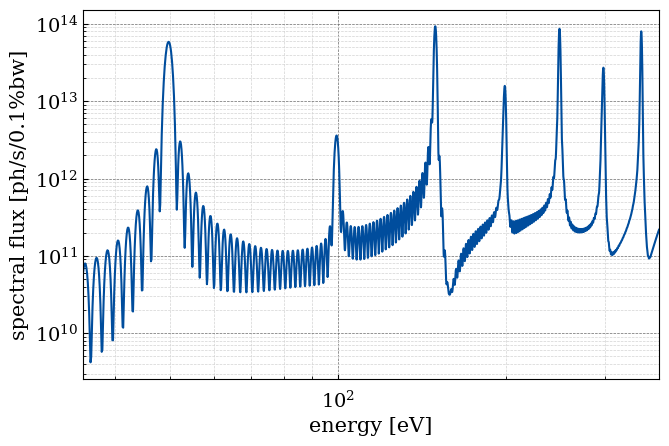

In [12]:
spectrum = read_spectrum([".\example_01\SOLEIL-tabU64mm_slit_me_spectrum.h5"])

img = PlotManager(spectrum["spectrum"]["flux"],  spectrum["spectrum"]["energy"])
img.additional_info(None, "energy [eV]",  "spectral flux [ph/s/0.1%bw]")
img.aesthetics(400, True, True, 3 , 1, True, 4).info_1d_plot(0, None, 1, "-", False, 0, 1).plot_1d(enable=True)

## Comparison between the ideal and tabulated undulators

### On axis flux

.\example_01\SOLEIL-U64mm_on_axis_spectrum.h5
.\example_01\SOLEIL-tabU64mm_on_axis_spectrum.h5


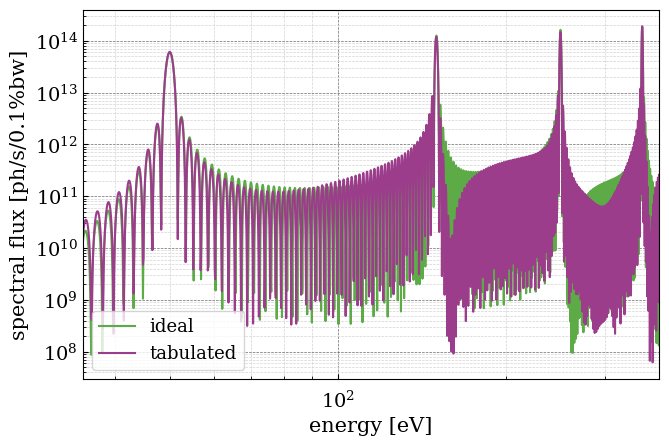

In [13]:
spectrum = read_spectrum([".\example_01\SOLEIL-U64mm_on_axis_spectrum.h5"])
img = PlotManager(spectrum["spectrum"]["flux"],  spectrum["spectrum"]["energy"])
img.additional_info(None, "energy [eV]",  "spectral flux [ph/s/0.1%bw]")
img.aesthetics(400, True, True, 3 , 1, True, 2)
img.info_1d_plot(2, "ideal", 0, '-', False, 0, 1).plot_1d(enable=False, hold=False)
spectrum = read_spectrum([".\example_01\SOLEIL-tabU64mm_on_axis_spectrum.h5"])
img.image = spectrum["spectrum"]["flux"]
img.x = spectrum["spectrum"]["energy"]
img.info_1d_plot(3, "tabulated", 0, '-', False, 0, 1).plot_1d(enable=True, hold=True)

### Flux through a slit

.\example_01\SOLEIL-U64mm_slit_spectrum.h5
.\example_01\SOLEIL-U64mm_slit_me_spectrum.h5
.\example_01\SOLEIL-tabU64mm_slit_me_spectrum.h5


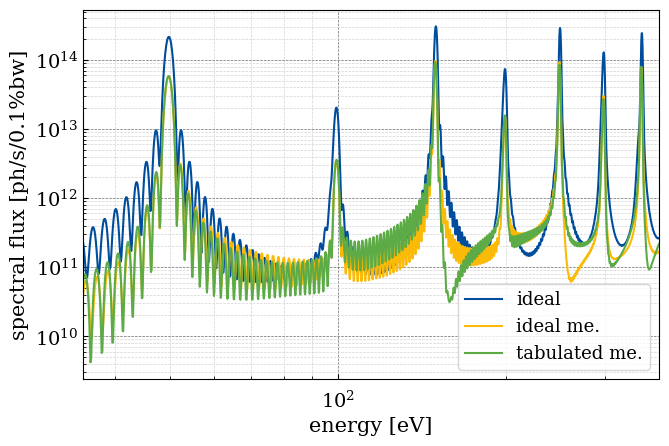

In [14]:
spectrum = read_spectrum([".\example_01\SOLEIL-U64mm_slit_spectrum.h5"])
img = PlotManager(spectrum["spectrum"]["flux"],  spectrum["spectrum"]["energy"])
img.additional_info(None, "energy [eV]",  "spectral flux [ph/s/0.1%bw]")
img.aesthetics(400, True, True, 3 , 1, True, 2)
img.info_1d_plot(0, "ideal", 0, '-', False, 0, 1).plot_1d(enable=False, hold=False)
spectrum = read_spectrum([".\example_01\SOLEIL-U64mm_slit_me_spectrum.h5"])
img.image = spectrum["spectrum"]["flux"]
img.x = spectrum["spectrum"]["energy"]
img.info_1d_plot(1, "ideal me.", 0, '-', False, 0, 1).plot_1d(enable=False, hold=True)
spectrum = read_spectrum([".\example_01\SOLEIL-tabU64mm_slit_me_spectrum.h5"])
img.image = spectrum["spectrum"]["flux"]
img.x = spectrum["spectrum"]["energy"]
img.info_1d_plot(2, "tabulated me.", 0, '-', False, 0, 1).plot_1d(enable=True, hold=True)

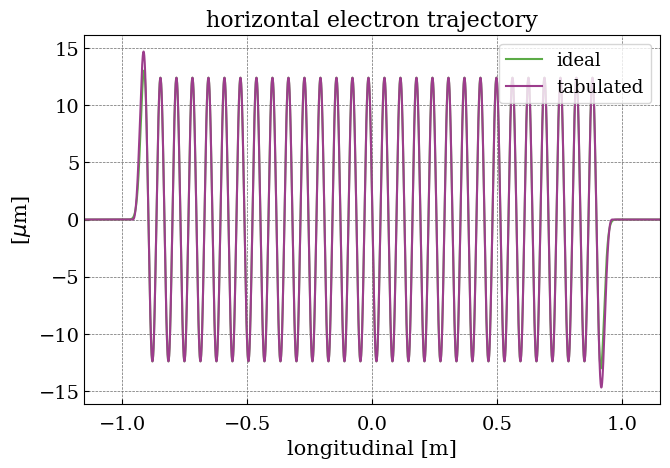

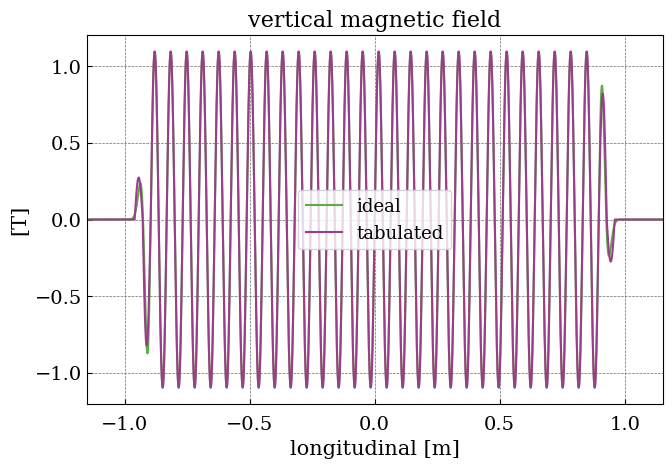

In [15]:
eTraj_ideal = read_electron_trajectory(r".\example_01\SOLEIL-U64mm_on_axis_eTraj.dat")
eTraj_meas = read_electron_trajectory(r".\example_01\SOLEIL-tabU64mm_on_axis_eTraj.dat")

img = PlotManager(eTraj_ideal["X"]*1E6, eTraj_ideal["Z"])
img.additional_info("horizontal electron trajectory", "longitudinal [m]", "[$\mu$m]")
img.aesthetics(400, True, True, 0 , 1, True, 2)
img.info_1d_plot(2, "ideal", 0, '-', False, 0, 1).plot_1d(enable=False, hold=False)
img.image = eTraj_meas["X"]*1E6
img.x = eTraj_meas["Z"]
img.info_1d_plot(3, "tabulated", 0, '-', False, 0, 1).plot_1d(enable=True, hold=True)

img = PlotManager(eTraj_ideal["By"], eTraj_ideal["Z"])
img.additional_info("vertical magnetic field", "longitudinal [m]", "[T]")
img.aesthetics(400, True, True, 0 , 1, True, 2)
img.info_1d_plot(2, "ideal", 0, '-', False, 0, 1).plot_1d(enable=False, hold=False)
img.image = eTraj_meas["By"]
img.x = eTraj_meas["Z"]
img.info_1d_plot(3, "tabulated", 0, '-', False, 0, 1).plot_1d(enable=True, hold=True)